
# Pietroiusti et al. 2023 ESD: Create interpolated lake level time series 1896-2022, part 2

## Data sources: 
- DAHITI, 2022 March download
- WMO Hydromet 1948-1995/1996 (from Vanderkelen et al 2018)
- HC monthly data late 1800s to today

## What this notebook does: 
- merge together the DH and HM and HC timeseries late 1800s-2022
    - calculates average difference from overlapping dates
    - corrects timeseries to match
    - overwrites overlapping periods with DH
    - interpolate to daily resolution

    
## Output: 
- lake level HC + DH + HM (1896-2022) lakelevel_ext_intr_HCDH22.csv


last update: Feb 2023 

contact: rosa.pietroiusti@vub.be



In [1]:

#=============#
#== IMPORTS ==#
#=============#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import math
import os , glob
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

#=====================#
#== DATA + PLOTTING ==#
#=====================#

# new input data path
data_path = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')

# Hydromet + Dahiti interpolated data (daily HM, approx 10-daily DH)
filepath = os.path.join(data_path,'data-modified', 'lakelevels','lakelevel_all_intr_DH22.csv')
lakelevels_intr = pd.read_csv(filepath)
lakelevels_intr['date'] = pd.to_datetime(lakelevels_intr['date'])
lakelevels_intr = lakelevels_intr.set_index('date')

# Hydromet + Dahiti raw, not interpolated
filepath = os.path.join(data_path,'data-modified', 'lakelevels', 'lakelevel_all_raw_DH22.csv')
lakelevels_raw = pd.read_csv(filepath)
lakelevels_raw['date'] = pd.to_datetime(lakelevels_raw['date'])
lakelevels_raw = lakelevels_raw.set_index('date')

# HM data from Vanderkelen et al 2018
filepath = os.path.join(data_path,'input-data', 'lakelevels','Jinja_lakelevels_Van.txt')
lakelevels_jinja_raw = pd.read_csv(filepath, sep="\t", header=None)
lakelevels_jinja_raw.columns = ['year', 'month', 'day', 'water_level', 'in_situ']
dates = pd.to_datetime(lakelevels_jinja_raw[['year', 'month', 'day']])
df = pd.DataFrame(dates, columns = ['date'])
df[['water_level', 'in_situ']] = lakelevels_jinja_raw[['water_level', 'in_situ']]
lakelevels_jinja = df.set_index(['date'])
lakelevels_jinja.replace(0, np.nan, inplace=True)

# From UKCEH from 1896 monthly data
lakelevels_file = os.path.join(data_path,'input-data','lakelevels','HoughtonCarr_lakelevels.csv')
lakelevels_HC = pd.read_csv(lakelevels_file, header=None)

# Clean UKCEH levels 
startdate = np.datetime64('1896-01')
enddate = np.datetime64('2017-12')
alldays = pd.DataFrame(pd.date_range(start=startdate,end=enddate, freq='MS'))

df_HC = pd.merge(alldays, lakelevels_HC.iloc[:,2], left_index=True, right_index=True)
df_HC.columns = ['date', 'levels']
df_HC = df_HC.set_index('date')

In [2]:
# make figures directory
figDIR = os.path.join(os.path.dirname(os.getcwd()), '..', 'figures')
fig_path = os.path.join(figDIR, 'figures_1_feb23_extendedlevels')

if os.path.exists(fig_path):
    print("The directory", fig_path, "exists!")
else:
    os.makedirs(fig_path)
    print("The directory", fig_path, "was made!")


The directory C:\Users\rpietroi\OneDrive - Vrije Universiteit Brussel\repos_cloud\lakevic-eea\lakevic-eea-scripts\lakevic-eea-scripts\..\figures\figures_1_feb23_extendedlevels exists!


In [3]:
lakelevels_intr

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-02-27,1136.228
2022-02-28,1136.228
2022-03-01,1136.229


<AxesSubplot: xlabel='date'>

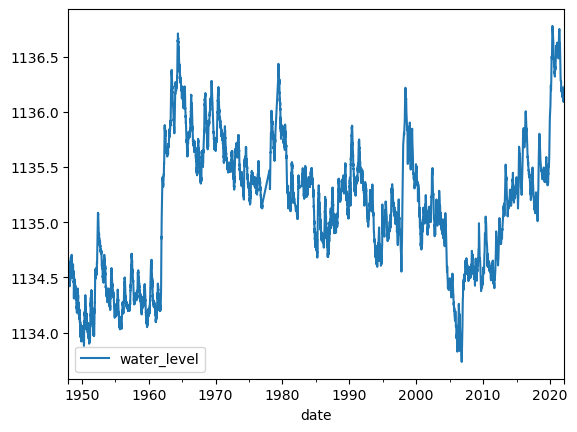

In [4]:
lakelevels_intr.plot()

In [6]:
lakelevels_raw


,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


<AxesSubplot: xlabel='date'>

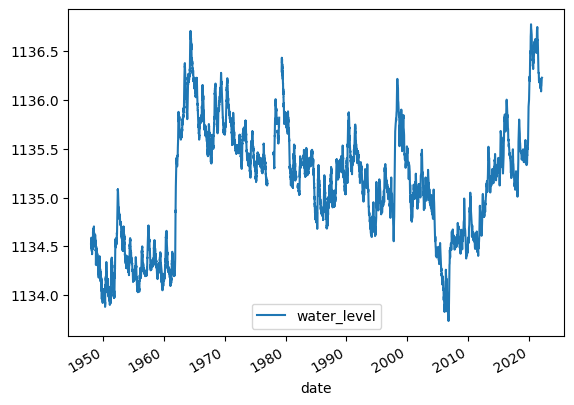

In [7]:
lakelevels_raw.plot()

In [8]:
df_HC

,levels
date,
1896-01-01,11.57
1896-02-01,11.50
1896-03-01,11.51
1896-04-01,11.53
1896-05-01,11.53
...,...
2017-08-01,11.84
2017-09-01,11.83
2017-10-01,11.86


<AxesSubplot: xlabel='date'>

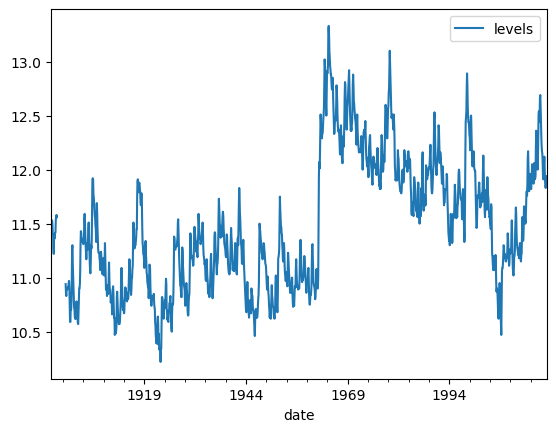

In [9]:
df_HC.plot()

In [10]:
df_HC.max()

levels    13.33
dtype: float64

In [11]:
df_HC[df_HC['levels'] == df_HC['levels'].max()]

,levels
date,
1964-05-01,13.33


In [12]:
lakelevels_jinja

,water_level,in_situ
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [13]:
lakelevels_jinja.loc['1964-05-01'] # Data agrees  

water_level    1136.217
in_situ          13.330
Name: 1964-05-01 00:00:00, dtype: float64

In [14]:
lakelevels_jinja['water_level'] - lakelevels_jinja['in_situ']  # 1122.887

date
1948-01-01    1122.887
1948-01-02    1122.887
1948-01-03    1122.887
1948-01-04    1122.887
1948-01-05    1122.887
                ...   
1996-07-28    1122.887
1996-07-29    1122.887
1996-07-30    1122.887
1996-07-31    1122.887
1996-08-01    1122.887
Length: 17746, dtype: float64

In [15]:
lakelevels_raw['water_level'] - lakelevels_jinja['water_level']

date
1948-01-01    0.432
1948-01-02    0.432
1948-01-03    0.432
1948-01-04    0.432
1948-01-05    0.432
              ...  
2022-01-22      NaN
2022-02-01      NaN
2022-02-11      NaN
2022-02-21      NaN
2022-03-03      NaN
Name: water_level, Length: 18667, dtype: float64

In [16]:
(lakelevels_raw['water_level'] - 1122.887).max() - 0.432

13.4580000000001

In [17]:
 1122.887 + 0.432

1123.319

In [18]:
# Turn DAHITI and HYDROMET RAW to in situ to combine with HC
geoid_corr =  1122.887
HM_to_DH_corr = 0.432

df_new_insitu = lakelevels_raw['water_level']   - geoid_corr - HM_to_DH_corr
df_new_insitu

date
1948-01-01    11.210
1948-01-02    11.215
1948-01-03    11.175
1948-01-04    11.165
1948-01-05    11.190
               ...  
2022-01-22    12.824
2022-02-01    12.826
2022-02-11    12.880
2022-02-21    12.908
2022-03-03    12.910
Name: water_level, Length: 17399, dtype: float64

In [19]:
geoid_corr + HM_to_DH_corr

1123.319

<AxesSubplot: xlabel='date'>

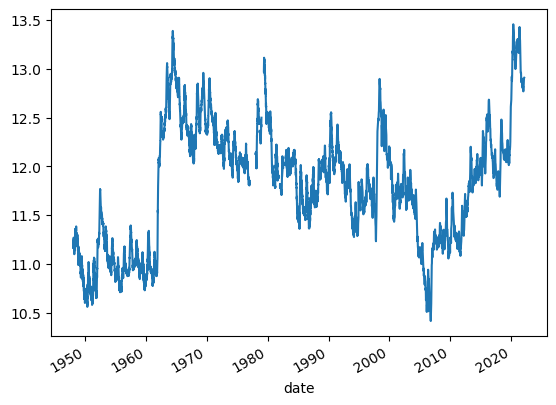

In [20]:
df_new_insitu.plot() # hydromet 1948-1992, dahiti 1992-2022, RAW

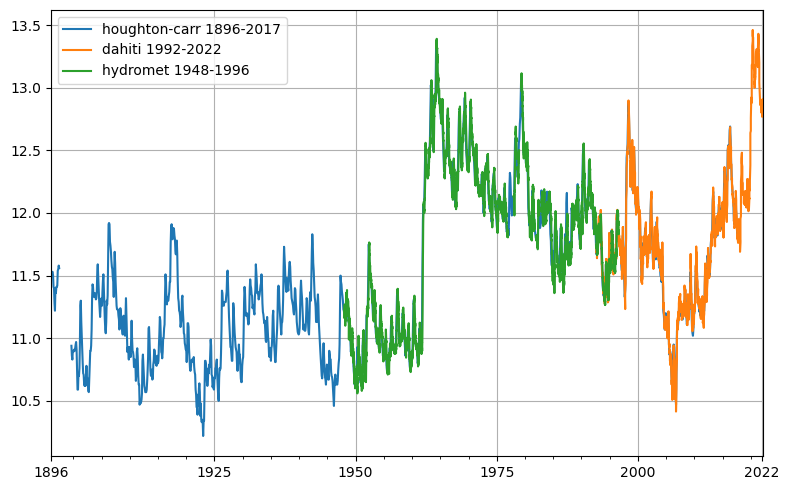

In [22]:
# Plot the three together, check that they agree

# set x axis labels
xlist = pd.to_datetime([1896, 1925, 1950, 1975,2000,2022], format='%Y')

fig, ax = plt.subplots(figsize=(8, 5))
df_HC['levels'].plot(ax=ax, label='houghton-carr 1896-2017') # houghton-carr data
df_new_insitu.loc['1992-9-1':].plot(ax=ax, label='dahiti 1992-2022') # dahiti data
lakelevels_jinja['in_situ'].plot(ax=ax, label='hydromet 1948-1996') # hydromet data
ax.grid(True)
ax.legend()
plt.xlabel("")

# Set xaxis labels
ax.xaxis.set_ticks(xlist)
ax.xaxis.set_ticklabels(xlist.strftime("%Y"))


fig.tight_layout()

#plt.savefig(os.path.join(fig_path,'LL_plot_extended_1896_2022_allsources_insitu_v2.png'),dpi=300)

In [27]:
df_new_insitu_df = pd.DataFrame(df_new_insitu)
df_new_insitu_df 

,water_level
date,
1948-01-01,11.210
1948-01-02,11.215
1948-01-03,11.175
1948-01-04,11.165
1948-01-05,11.190
...,...
2022-01-22,12.824
2022-02-01,12.826
2022-02-11,12.880


In [37]:
frames = [df_HC['levels'].loc[:'1947-12-01'], lakelevels_jinja['in_situ'].loc[:'1992-9-26'], df_new_insitu_df['water_level'].loc['1992-09-27':]]
unified_levels = pd.DataFrame(pd.concat(frames), columns=['water_level'])
unified_levels

,water_level
date,
1896-01-01,11.570
1896-02-01,11.500
1896-03-01,11.510
1896-04-01,11.530
1896-05-01,11.530
...,...
2022-01-22,12.824
2022-02-01,12.826
2022-02-11,12.880


In [38]:
df_HC['levels'].loc[:'1947-12-01']

date
1896-01-01    11.57
1896-02-01    11.50
1896-03-01    11.51
1896-04-01    11.53
1896-05-01    11.53
              ...  
1947-08-01    11.37
1947-09-01    11.34
1947-10-01    11.30
1947-11-01    11.23
1947-12-01    11.22
Name: levels, Length: 624, dtype: float64

In [39]:
lakelevels_jinja['in_situ'].loc[:'1992-9-26']

date
1948-01-01    11.210
1948-01-02    11.215
1948-01-03    11.175
1948-01-04    11.165
1948-01-05    11.190
               ...  
1992-09-22    11.715
1992-09-23    11.705
1992-09-24    11.690
1992-09-25    11.700
1992-09-26    11.695
Name: in_situ, Length: 16341, dtype: float64

In [41]:
data_path

'C:\\Users\\rpietroi\\OneDrive - Vrije Universiteit Brussel\\repos_cloud\\lakevic-eea\\lakevic-eea-scripts\\lakevic-eea-scripts\\..\\data'

### save

In [47]:
# interpolate to daily and save this as csv 

unified_levels_intr = unified_levels.resample('D').asfreq().interpolate(method='linear').round(3)
#unified_levels_intr.to_csv(os.path.join(data_path,'data-modified','lakelevels','lakelevel_ext_intr_HCDH22.csv'),sep=',', index=True, header=True)
unified_levels_intr


,water_level
date,
1896-01-01,11.570
1896-01-02,11.568
1896-01-03,11.565
1896-01-04,11.563
1896-01-05,11.561
...,...
2022-02-27,12.909
2022-02-28,12.909
2022-03-01,12.910


0
2020-05-17 00:00:00
1
1964-05-15 00:00:00
2
1979-05-23 00:00:00
3
1998-05-22 00:00:00
4
1906-05-01 00:00:00
5
1917-06-01 00:00:00
6
1942-05-01 00:00:00
7
1923-01-01 00:00:00
8
2006-10-21 00:00:00


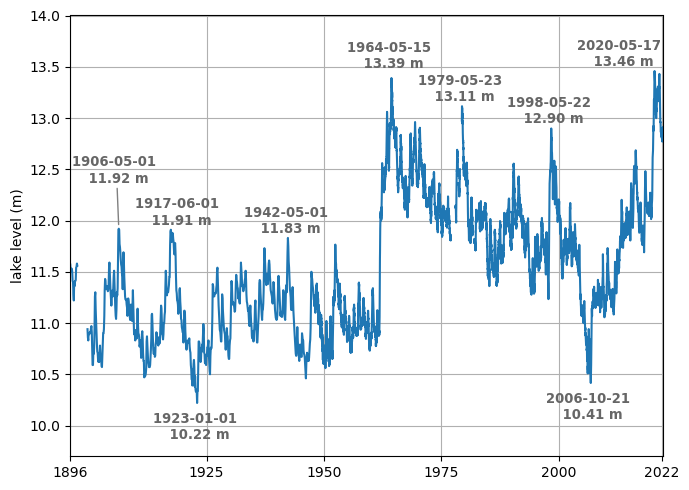

In [38]:
# plot Figure 1 of paper levels labelled
# UKCEH 1896-1948, hydromet 1948-1992, dahiti 1992-2022
# including also pre-1964 peaks 
# with 1917 peak as well
# with month-day

# Get extreme high levs
high_levs = unified_levels[unified_levels['water_level'] > 1136 - 1123.319]

# Get high levs before 1960s spike
high_levs = pd.concat([unified_levels[unified_levels['water_level'] > 11.7].loc[:'1963-01-01'], high_levs] )
list_years = np.unique(high_levs.index.year)

# Pick one per year
high_dates = []
high_levs_list =[]

for i in list_years:
    filter_condition = (high_levs.index.year == i)
    df_filter = high_levs.loc[filter_condition]
    maxL = max(df_filter['water_level'])
    maxday = df_filter[df_filter['water_level'] == maxL].index[0]
    high_levs_list.append(maxL)
    high_dates.append(maxday)
    
# Manually select only ones I want to show
data = {'date': high_dates,
        'level': high_levs_list
        }
df = pd.DataFrame(data)
df = df.sort_values(by='level', ascending=False).reset_index(drop=True)
select = [0,2,3,9,16,17,18] #  2020, 1964, 1979, 1998, 1906, 1917, 1942
df_select = df.iloc[select]

# Get low levels 
low_levs = unified_levels[unified_levels['water_level'] < 10.5]
list_years = np.unique(low_levs.index.year)

low_dates = []
low_levs_list =[]

for i in list_years:
    filter_condition = (low_levs.index.year == i)
    df_filter = low_levs.loc[filter_condition]
    minL = min(df_filter['water_level'])
    minday = df_filter[df_filter['water_level'] == minL].index[0]
    low_levs_list.append(minL)
    low_dates.append(minday)

# manually select which to show
data = {'date': low_dates,
        'level': low_levs_list
        }
df = pd.DataFrame(data)
df = df.sort_values(by='level', ascending=True).reset_index(drop=True)
#print(df)
select = [0,2]
df_select = pd.concat([df_select, df.iloc[select]])

# PLOT 

# set x axis labels
xlist = pd.to_datetime([1896, 1925, 1950, 1975,2000,2022], format='%Y')

fig, ax = plt.subplots(figsize=(7,5)) 
unified_levels.plot(ax=ax)
ax.grid(True)
plt.xlabel("")
plt.ylabel("lake level (m)")

# Set xaxis labels
ax.xaxis.set_ticks(xlist)
ax.xaxis.set_ticklabels(xlist.strftime("%Y"), rotation=0,ha='center')

# set plot limits
left = '1896-01-01'
right = '2022-03-03' #2022-03-03
ax.set_ylim(9.7 ,14) #9.51
ax.set_xlim(left, right)

# Add labels on extremes
for tick,label,i in zip(df_select['date'] , df_select['level'], range(len(df_select))):
    print(i)
    print(tick)
    #x
    if i == 0:
        tick_plot = tick - pd.Timedelta(days=(365*7))
    elif i in {5}:
        tick_plot = tick + pd.Timedelta(days=(365*1.8))
    elif i in {4}:
        tick_plot = tick - pd.Timedelta(days=(365*.5))
    else: 
        tick_plot = tick
    # y
    if i in {4}:
        tick_y = label+0.45
    elif i in {8,7}:
        tick_y = label-0.35
    elif i in {1}:
        tick_y = label+0.1
    else:
        tick_y=label+0.05
        
    if i == 4:
        ax.annotate('{} \n {:.2f} m'.format(tick.strftime('%Y-%m-%d'), label), xy=(tick, label), xytext=(tick_plot, tick_y),
                    horizontalalignment='center', weight='heavy', color='0.4', fontsize=9.5,
                    arrowprops=dict(arrowstyle='-',shrinkA=0,shrinkB=3,color='gray')) #facecolor='0.4', shrinkB=100, width=0.1, headwidth=0
    else:
        ax.text(tick_plot, #x
                tick_y ,  #y
                '{} \n {:.2f} m'.format(tick.strftime('%Y-%m-%d'), label), #text tick.strftime('%Y-%m-%d')
                horizontalalignment='center', weight='heavy', color='0.4', #color 0.3
                fontsize=9.5)



plt.legend('',frameon=False)
fig.tight_layout()

#plt.savefig(os.path.join(fig_path,'LL_plot_extended_1896_2022_insitu_monthday_arrow_light_v4.pdf'),dpi=300)